# Face Generation

In this project, you'll define and train a Generative Adverserial network of your own creation on a dataset of faces. Your goal is to get a generator network to generate *new* images of faces that look as realistic as possible!

The project will be broken down into a series of tasks from **defining new architectures training adversarial networks**. At the end of the notebook, you'll be able to visualize the results of your trained Generator to see how it performs; your generated samples should look like fairly realistic faces with small amounts of noise.

### Get the Data

You'll be using the [CelebFaces Attributes Dataset (CelebA)](http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html) to train your adversarial networks.

This dataset has higher resolution images than datasets you have previously worked with (like MNIST or SVHN) you've been working with, and so, you should prepare to define deeper networks and train them for a longer time to get good results. It is suggested that you utilize a GPU for training.

### Pre-processed Data

Since the project's main focus is on building the GANs, we've done *some* of the pre-processing for you. Each of the CelebA images has been cropped to remove parts of the image that don't include a face, then resized down to 64x64x3 NumPy images. Some sample data is show below.

<img src='assets/processed_face_data.png' width=60% />

> If you are working locally, you can download this data [by clicking here](https://s3.amazonaws.com/video.udacity-data.com/topher/2018/November/5be7eb6f_processed-celeba-small/processed-celeba-small.zip)

This is a zip file that you'll need to extract in the home directory of this notebook for further loading and processing. After extracting the data, you should be left with a directory of data `processed-celeba-small/`.

In [1]:
# run this once to unzip the file
#!unzip processed-celeba-small.zip

In [2]:
from pathlib import Path
import matplotlib.image as mpimg

from glob import glob
from typing import Tuple, Callable, Dict

import matplotlib.pyplot as plt
import numpy as np
import torch
from PIL import Image
from torch.utils.data import DataLoader, Dataset
from torchvision.transforms import Compose, ToTensor, Resize, Normalize
import torch.nn as nn

import tests

In [3]:
data_dir = 'processed_celeba_small/celeba/'

## Data pipeline

The [CelebA](http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html) dataset contains over 200,000 celebrity images with annotations. Since you're going to be generating faces, you won't need the annotations, you'll only need the images. Note that these are color images with [3 color channels (RGB)](https://en.wikipedia.org/wiki/Channel_(digital_image)#RGB_Images) each.

### Pre-process and Load the Data

Since the project's main focus is on building the GANs, we've done *some* of the pre-processing for you. Each of the CelebA images has been cropped to remove parts of the image that don't include a face, then resized down to 64x64x3 NumPy images. This *pre-processed* dataset is a smaller subset of the very large CelebA dataset and contains roughly 30,000 images. 

Your first task consists in building the dataloader. To do so, you need to do the following:
* implement the get_transforms function
* create a custom Dataset class that reads the CelebA data

### Exercise: implement the get_transforms function

The `get_transforms` function should output a [`torchvision.transforms.Compose`](https://pytorch.org/vision/stable/generated/torchvision.transforms.Compose.html#torchvision.transforms.Compose) of different transformations. You have two constraints:
* the function takes a tuple of size as input and should **resize the images** to the input size
* the output images should have values **ranging from -1 to 1**

In [4]:
def get_transforms(size: Tuple[int, int]) -> Callable:
    """ Transforms to apply to the image."""
    # TODO: edit this function by appening transforms to the below list
    transforms = [ToTensor(), Resize(size), Normalize(0.5,0.5)]
    
    return Compose(transforms)

### Exercise: implement the DatasetDirectory class


The `DatasetDirectory` class is a torch Dataset that reads from the above data directory. The `__getitem__` method should output a transformed tensor and the `__len__` method should output the number of files in our dataset. You can look at [this custom dataset](https://pytorch.org/tutorials/beginner/basics/data_tutorial.html#creating-a-custom-dataset-for-your-files) for ideas. 

In [5]:

class DatasetDirectory(Dataset):
    """
    A custom dataset class that loads images from folder.
    args:
    - directory: location of the images
    - transform: transform function to apply to the images
    - extension: file format
    """
    def __init__(self, 
                 directory: str, 
                 transforms: Callable = None, 
                 extension: str = '.jpg'):
        # TODO: implement the init method

        images = list(Path(directory).glob(f"*{extension}"))
        self.images = [transforms(mpimg.imread(str(p))) for p in images]
        
    def __len__(self) -> int:
        """ returns the number of items in the dataset """
        # TODO: return the number of elements in the dataset
        return len(self.images)

    def __getitem__(self, index: int) -> torch.Tensor:
        """ load an image and apply transformation """
        # TODO: return the index-element of the dataset
        return self.images[index]

In [6]:
"""
DO NOT MODIFY ANYTHING IN THIS CELL
"""
# run this cell to verify your dataset implementation
dataset = DatasetDirectory(data_dir, get_transforms((64, 64)))
tests.check_dataset_outputs(dataset)

/opt/conda/lib/python3.7/site-packages/torchvision/transforms/functional.py:114: UserWarning: The given NumPy array is not writable, and PyTorch does not support non-writable tensors. This means writing to this tensor will result in undefined behavior. You may want to copy the array to protect its data or make it writable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  ../torch/csrc/utils/tensor_numpy.cpp:178.)
  img = torch.from_numpy(pic.transpose((2, 0, 1))).contiguous()


Congrats, your dataset implementation passed all the tests


The functions below will help you visualize images from the dataset.

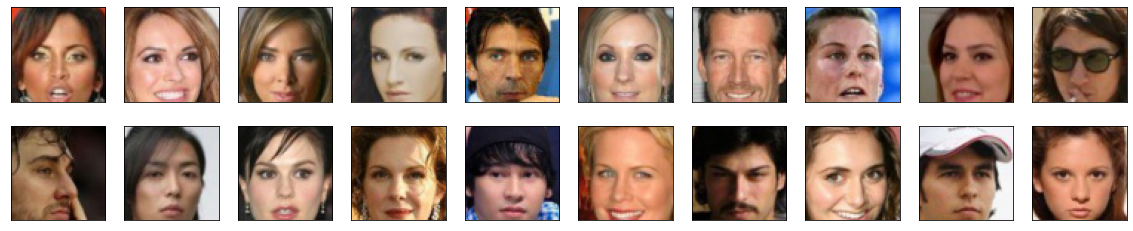

In [7]:
"""
DO NOT MODIFY ANYTHING IN THIS CELL
"""

def denormalize(images):
    """Transform images from [-1.0, 1.0] to [0, 255] and cast them to uint8."""
    return ((images + 1.) / 2. * 255).astype(np.uint8)

# plot the images in the batch, along with the corresponding labels
fig = plt.figure(figsize=(20, 4))
plot_size=20
for idx in np.arange(plot_size):
    ax = fig.add_subplot(2, int(plot_size/2), idx+1, xticks=[], yticks=[])
    img = dataset[idx].numpy()
    img = np.transpose(img, (1, 2, 0))
    img = denormalize(img)
    ax.imshow(img)

## Model implementation

As you know, a GAN is comprised of two adversarial networks, a discriminator and a generator. Now that we have a working data pipeline, we need to implement the discriminator and the generator. 

Feel free to implement any additional class or function.

### Exercise: Create the discriminator

The discriminator's job is to score real and fake images. You have two constraints here:
* the discriminator takes as input a **batch of 64x64x3 images**
* the output should be a single value (=score)

Feel free to get inspiration from the different architectures we talked about in the course, such as DCGAN, WGAN-GP or DRAGAN.

#### Some tips
* To scale down from the input image, you can either use `Conv2d` layers with the correct hyperparameters or Pooling layers.
* If you plan on using gradient penalty, do not use Batch Normalization layers in the discriminator.

In [8]:
from torch.nn import Module

In [9]:
class Discriminator(Module):
    def __init__(self):
        super(Discriminator, self).__init__()
        factor = 128
        # TODO: instantiate the different layers
        
        # constraint: "input is a batch of 64x64x3 images"
        self.conv1 = nn.Conv2d(3,factor,4,2,1)
        self.conv2 = nn.Conv2d(factor,factor*2,4,2,1)
        self.conv3 = nn.Conv2d(factor*2,factor*4,4,2,1)
        self.bn2 = nn.BatchNorm2d(factor*2)
        self.bn3 = nn.BatchNorm2d(factor*4)
        self.act = nn.LeakyReLU()
        self.flatten = nn.Flatten()
        self.fc = nn.Linear(factor*4*8*8,1)
        
    def forward(self, x: torch.Tensor) -> torch.Tensor:
        # TODO: implement the forward method
        #x = np.transpose(x,(0,3,1,2))
        x = self.conv1(x)
        x = self.act(x)
        x = self.conv2(x)
        x = self.bn2(x)
        x = self.act(x)
        x = self.conv3(x)
        x = self.bn3(x)
        x = self.act(x)
        x = self.flatten(x)
        x = self.fc(x)
        
        return x
    
# hallo

In [10]:
img=dataset[0]
print(img.shape)
#img = np.transpose(img, (1, 2, 0))
D = Discriminator()
img = D(torch.unsqueeze(img,0))

img.shape


torch.Size([3, 64, 64])


torch.Size([1, 1])

In [11]:
"""
DO NOT MODIFY ANYTHING IN THIS CELL
"""
# run this cell to check your discriminator implementation
discriminator = Discriminator()
#tests.check_discriminator(discriminator)



### Exercise: create the generator

The generator's job creates the "fake images" and learns the dataset distribution. You have three constraints here:
* the generator takes as input a vector of dimension `[batch_size, latent_dimension, 1, 1]`
* the generator must outputs **64x64x3 images**

Feel free to get inspiration from the different architectures we talked about in the course, such as DCGAN, WGAN-GP or DRAGAN.

#### Some tips:
* to scale up from the latent vector input, you can use `ConvTranspose2d` layers
* as often with Gan, **Batch Normalization** helps with training

In [12]:
class Generator(Module):
    def __init__(self, latent_dim: int):
        super(Generator, self).__init__()
        # TODO: instantiate the different layers
        factor = 16
        self.fc = nn.Linear(latent_dim * 1 * 1, factor * 32)
        self.deconv1 = nn.ConvTranspose2d(factor * 32, factor *16, 4,2,1)
        self.bn1 = nn.BatchNorm2d(factor*16)
        self.deconv2 = nn.ConvTranspose2d(factor*16,factor*8,4,2,1)
        self.bn2 = nn.BatchNorm2d(factor*8)
        self.deconv3 = nn.ConvTranspose2d(factor*8,factor*4,4,2,1)
        self.bn3 = nn.BatchNorm2d(factor*4)
        self.deconv4 = nn.ConvTranspose2d(factor*4,factor*2,4,2,1)
        self.bn4 = nn.BatchNorm2d(factor*2)
        self.deconv5 = nn.ConvTranspose2d(factor*2,factor,4,2,1)
        self.bn5 = nn.BatchNorm2d(factor)
        self.deconv6 = nn.ConvTranspose2d(factor,3,4,2,1)
        self.act = nn.ReLU()
        self.final_act = nn.Tanh()
        

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        # TODO: implement the forward method
        x = torch.permute(x, (0,2,3,1))
        x = self.fc(x)
        x = torch.permute(x, (0,3,1,2))
        x = self.deconv1(x)
        x = self.bn1(x)
        x = self.act(x)
        x = self.deconv2(x)
        x = self.bn2(x)
        x = self.act(x)
        x = self.deconv3(x)
        x = self.bn3(x)
        x = self.act(x)
        x = self.deconv4(x)
        x = self.bn4(x)
        x = self.act(x)
        x = self.deconv5(x)
        x = self.bn5(x)
        x = self.act(x)
        x = self.deconv6(x)
        x = self.final_act(x)
        return x



In [13]:
"""
DO NOT MODIFY ANYTHING IN THIS CELL
"""
# run this cell to verify your generator implementation
latent_dim = 128
generator = Generator(latent_dim)
tests.check_generator(generator, latent_dim)


Congrats, your generator implementation passed all the tests


## Optimizer

In the following section, we create the optimizers for the generator and discriminator. You may want to experiment with different optimizers, learning rates and other hyperparameters as they tend to impact the output quality.

### Exercise: implement the optimizers

In [14]:
import torch.optim as optim


def create_optimizers(generator: Module, discriminator: Module, lr: int):
    """ This function should return the optimizers of the generator and the discriminator """
    # TODO: implement the generator and discriminator optimizers
    g_optimizer = optim.Adam(generator.parameters(), lr)
    d_optimizer = optim.Adam(discriminator.parameters(), lr)
    return g_optimizer, d_optimizer


## Losses implementation

In this section, we are going to implement the loss function for the generator and the discriminator. You can and should experiment with different loss function.

Some tips:
* You can choose the commonly used the binary cross entropy loss or select other losses we have discovered in the course, such as the Wasserstein distance.
* You may want to implement a gradient penalty function as discussed in the course. It is not required and the code will work whether you implement it or not.

### Exercise: implement the generator loss

The generator's goal is to get the discriminator to think its generated images (= "fake" images) are real.

In [15]:
def generator_loss(fake_logits):
    """ Generator loss, takes the fake scores as inputs. """
    # TODO: implement the generator loss
    # fake_logits = D(G(z))
    criterion = nn.BCEWithLogitsLoss()
    should_be = torch.ones([len(fake_logits),1]).to(device)
    assert fake_logits.shape == should_be.shape, f"sizes are not the same:  {fake_logits.shape} vs. {fake_logits.shape}"
    loss = criterion(fake_logits, should_be)
    
    return loss

### Exercise: implement the discriminator loss

We want the discriminator to give high scores to real images and low scores to fake ones and the discriminator loss should reflect that.

In [16]:
def discriminator_loss(real_logits, fake_logits, smooth=False):
    """ Discriminator loss, takes the fake and real logits as inputs. """
    # TODO: implement the discriminator loss 
    # fake_logits = D(G(z))
    # real_logits = D(img)
    criterion = nn.BCEWithLogitsLoss()
    should_be_ones = torch.ones([len(real_logits),1]).to(device)
    if smooth:
        should_be_ones -= 0.1
    should_be_zeros = torch.zeros([len(fake_logits),1]).to(device)
    loss_r = criterion(real_logits, should_be_ones) 
    loss_f = criterion(fake_logits, should_be_zeros)
    
    return loss_r + loss_f


### Exercise (Optional): Implement the gradient Penalty

In the course, we discussed the importance of gradient penalty in training certain types of Gans. Implementing this function is not required and depends on some of the design decision you made (discriminator architecture, loss functions).

In [17]:
def gradient_penalty(discriminator, real_samples, fake_samples):
    """ This function enforces """
    gp = 0
    # TODO (Optional): implement the gradient penalty
    return gp

## Training


Training will involve alternating between training the discriminator and the generator. You'll use your functions real_loss and fake_loss to help you calculate the discriminator losses.

* You should train the discriminator by alternating on real and fake images
* Then the generator, which tries to trick the discriminator and should have an opposing loss function

### Exercise: implement the generator step and the discriminator step functions

Each function should do the following:
* calculate the loss
* backpropagate the gradient
* perform one optimizer step

In [18]:
def generator_step(batch_size: int, latent_dim: int) -> Dict:
    """ One training step of the generator. """
    # TODO: implement the generator step (foward pass, loss calculation and backward pass)
    g_optimizer.zero_grad()
    
    
    z = torch.rand(batch_size,latent_dim,1,1).to(device)
    fake_imges = generator(z)
    fake_logits = discriminator(fake_imges)
    g_loss = generator_loss(fake_logits)
    
    g_loss.backward()
    g_optimizer.step()
    
    gp = None
    return {'loss': g_loss}


def discriminator_step(batch_size: int, latent_dim: int, real_images: torch.Tensor) -> Dict:
    """ One training step of the discriminator. """
    # TODO: implement the discriminator step (foward pass, loss calculation and backward pass)
    d_optimizer.zero_grad()
    

    z = torch.rand(batch_size,latent_dim,1,1)
    real_logits = discriminator(real_images)
    fake_imges = generator(z.to(device))
    fake_logits = discriminator(fake_imges.detach())
    d_loss = discriminator_loss(real_logits,fake_logits,True)
    
    d_loss.backward()
    d_optimizer.step()
    gp = None
    return {'loss': d_loss, 'gp': gp}

### Main training loop

You don't have to implement anything here but you can experiment with different hyperparameters.

In [19]:
from datetime import datetime

In [20]:
# you can experiment with different dimensions of latent spaces
latent_dim = 128

# update to cpu if you do not have access to a gpu
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')


# number of epochs to train your model
n_epochs = 20

# number of images in each batch
batch_size = 64

### my params
lr = 0.0002

In [21]:
"""
DO NOT MODIFY ANYTHING IN THIS CELL
"""
print_every = 50

# Create optimizers for the discriminator D and generator G
generator = Generator(latent_dim).to(device)
discriminator = Discriminator().to(device)
g_optimizer, d_optimizer = create_optimizers(generator, discriminator,lr)

dataloader = DataLoader(dataset, 
                        batch_size=64, 
                        shuffle=True, 
                        num_workers=4, 
                        drop_last=True,
                        pin_memory=False)

In [22]:
"""
DO NOT MODIFY ANYTHING IN THIS CELL
"""

def display(fixed_latent_vector: torch.Tensor):
    """ helper function to display images during training """
    fig = plt.figure(figsize=(14, 4))
    plot_size = 16
    for idx in np.arange(plot_size):
        ax = fig.add_subplot(2, int(plot_size/2), idx+1, xticks=[], yticks=[])
        img = fixed_latent_vector[idx, ...].detach().cpu().numpy()
        img = np.transpose(img, (1, 2, 0))
        img = denormalize(img)
        ax.imshow(img)
    plt.show()

### Exercise: implement the training strategy

You should experiment with different training strategies. For example:

* train the generator more often than the discriminator. 
* added noise to the input image
* use label smoothing

Implement with your training strategy below.

In [23]:
# with open('experiments.csv','w') as f:
#     f.write('model,optimizers,training_strategy,lr,gp,result\n')
with open('experiments.csv','a') as f:
    f.write('DCGAN,Adam,smooth,0.0002,None,None\n')
    

2023-07-29 13:41:31 | Epoch [1/20] | Batch 0/509 | d_loss: 3.2467 | g_loss: 0.8286
2023-07-29 13:41:51 | Epoch [1/20] | Batch 50/509 | d_loss: 0.3426 | g_loss: 6.7290
2023-07-29 13:42:11 | Epoch [1/20] | Batch 100/509 | d_loss: 0.3450 | g_loss: 7.5574
2023-07-29 13:42:31 | Epoch [1/20] | Batch 150/509 | d_loss: 0.3454 | g_loss: 8.1202
2023-07-29 13:42:51 | Epoch [1/20] | Batch 200/509 | d_loss: 0.3313 | g_loss: 7.3913
2023-07-29 13:43:11 | Epoch [1/20] | Batch 250/509 | d_loss: 0.3443 | g_loss: 7.4974
2023-07-29 13:43:32 | Epoch [1/20] | Batch 300/509 | d_loss: 0.3394 | g_loss: 6.5155
2023-07-29 13:43:52 | Epoch [1/20] | Batch 350/509 | d_loss: 0.3635 | g_loss: 5.2934
2023-07-29 13:44:12 | Epoch [1/20] | Batch 400/509 | d_loss: 0.3487 | g_loss: 6.3656
2023-07-29 13:44:32 | Epoch [1/20] | Batch 450/509 | d_loss: 0.3880 | g_loss: 6.5339
2023-07-29 13:44:53 | Epoch [1/20] | Batch 500/509 | d_loss: 0.3524 | g_loss: 7.1465


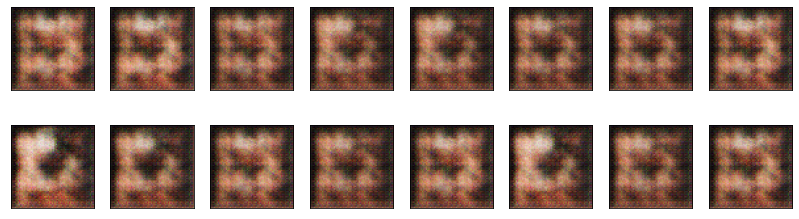

2023-07-29 13:44:59 | Epoch [2/20] | Batch 0/509 | d_loss: 0.3412 | g_loss: 7.0066
2023-07-29 13:45:19 | Epoch [2/20] | Batch 50/509 | d_loss: 0.3464 | g_loss: 5.9681
2023-07-29 13:45:40 | Epoch [2/20] | Batch 100/509 | d_loss: 0.3453 | g_loss: 6.7924
2023-07-29 13:46:00 | Epoch [2/20] | Batch 150/509 | d_loss: 0.3339 | g_loss: 6.5646
2023-07-29 13:46:20 | Epoch [2/20] | Batch 200/509 | d_loss: 0.3405 | g_loss: 6.5700
2023-07-29 13:46:41 | Epoch [2/20] | Batch 250/509 | d_loss: 0.3532 | g_loss: 6.6803
2023-07-29 13:47:01 | Epoch [2/20] | Batch 300/509 | d_loss: 0.3633 | g_loss: 7.1896
2023-07-29 13:47:21 | Epoch [2/20] | Batch 350/509 | d_loss: 0.3414 | g_loss: 6.5187
2023-07-29 13:47:42 | Epoch [2/20] | Batch 400/509 | d_loss: 0.3379 | g_loss: 6.2101
2023-07-29 13:48:02 | Epoch [2/20] | Batch 450/509 | d_loss: 0.3499 | g_loss: 5.5999
2023-07-29 13:48:23 | Epoch [2/20] | Batch 500/509 | d_loss: 0.3361 | g_loss: 7.2623


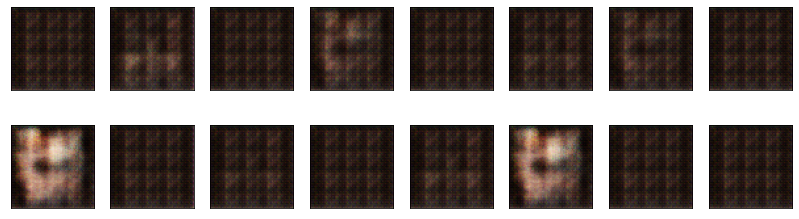

2023-07-29 13:48:29 | Epoch [3/20] | Batch 0/509 | d_loss: 0.3389 | g_loss: 6.5089
2023-07-29 13:48:49 | Epoch [3/20] | Batch 50/509 | d_loss: 0.3369 | g_loss: 6.9367
2023-07-29 13:49:09 | Epoch [3/20] | Batch 100/509 | d_loss: 0.3591 | g_loss: 7.9359
2023-07-29 13:49:30 | Epoch [3/20] | Batch 150/509 | d_loss: 0.3353 | g_loss: 7.4137
2023-07-29 13:49:50 | Epoch [3/20] | Batch 200/509 | d_loss: 0.3410 | g_loss: 7.5587
2023-07-29 13:50:11 | Epoch [3/20] | Batch 250/509 | d_loss: 0.3400 | g_loss: 6.5001
2023-07-29 13:50:31 | Epoch [3/20] | Batch 300/509 | d_loss: 0.3348 | g_loss: 6.9921
2023-07-29 13:50:51 | Epoch [3/20] | Batch 350/509 | d_loss: 0.3395 | g_loss: 8.5185
2023-07-29 13:51:12 | Epoch [3/20] | Batch 400/509 | d_loss: 0.3457 | g_loss: 6.4383
2023-07-29 13:51:32 | Epoch [3/20] | Batch 450/509 | d_loss: 0.3328 | g_loss: 7.0506
2023-07-29 13:51:52 | Epoch [3/20] | Batch 500/509 | d_loss: 0.3314 | g_loss: 7.4111


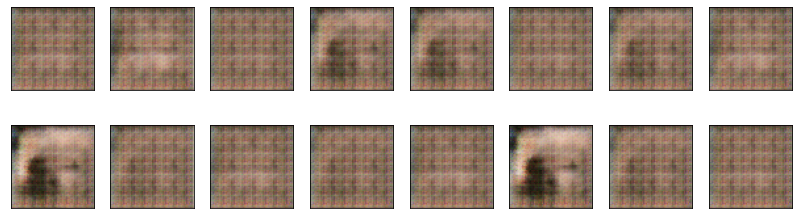

2023-07-29 13:51:59 | Epoch [4/20] | Batch 0/509 | d_loss: 0.3330 | g_loss: 7.6733
2023-07-29 13:52:19 | Epoch [4/20] | Batch 50/509 | d_loss: 0.3316 | g_loss: 7.8658
2023-07-29 13:52:40 | Epoch [4/20] | Batch 100/509 | d_loss: 0.3419 | g_loss: 7.9835
2023-07-29 13:53:00 | Epoch [4/20] | Batch 150/509 | d_loss: 0.3309 | g_loss: 7.4915
2023-07-29 13:53:21 | Epoch [4/20] | Batch 200/509 | d_loss: 0.3352 | g_loss: 6.6685
2023-07-29 13:53:41 | Epoch [4/20] | Batch 250/509 | d_loss: 0.3290 | g_loss: 7.4469
2023-07-29 13:54:01 | Epoch [4/20] | Batch 300/509 | d_loss: 0.3321 | g_loss: 7.2935
2023-07-29 13:54:22 | Epoch [4/20] | Batch 350/509 | d_loss: 0.3300 | g_loss: 7.1870
2023-07-29 13:54:42 | Epoch [4/20] | Batch 400/509 | d_loss: 0.3300 | g_loss: 7.2499
2023-07-29 13:55:02 | Epoch [4/20] | Batch 450/509 | d_loss: 0.3341 | g_loss: 6.5460
2023-07-29 13:55:23 | Epoch [4/20] | Batch 500/509 | d_loss: 0.3286 | g_loss: 7.3673


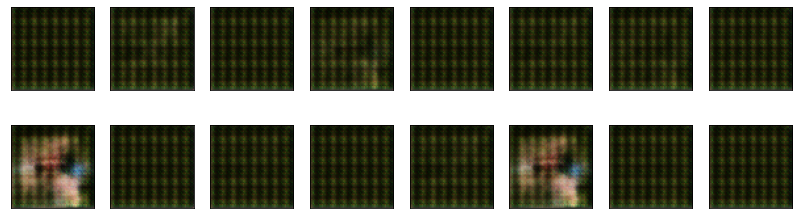

2023-07-29 13:55:29 | Epoch [5/20] | Batch 0/509 | d_loss: 0.3282 | g_loss: 7.6792
2023-07-29 13:55:49 | Epoch [5/20] | Batch 50/509 | d_loss: 0.3343 | g_loss: 6.9186
2023-07-29 13:56:10 | Epoch [5/20] | Batch 100/509 | d_loss: 0.3330 | g_loss: 7.8420
2023-07-29 13:56:30 | Epoch [5/20] | Batch 150/509 | d_loss: 0.3343 | g_loss: 6.8364
2023-07-29 13:56:50 | Epoch [5/20] | Batch 200/509 | d_loss: 0.3339 | g_loss: 7.0633
2023-07-29 13:57:11 | Epoch [5/20] | Batch 250/509 | d_loss: 0.3342 | g_loss: 7.1823
2023-07-29 13:57:31 | Epoch [5/20] | Batch 300/509 | d_loss: 0.3352 | g_loss: 7.4551
2023-07-29 13:57:52 | Epoch [5/20] | Batch 350/509 | d_loss: 0.3296 | g_loss: 8.3158
2023-07-29 13:58:12 | Epoch [5/20] | Batch 400/509 | d_loss: 0.3333 | g_loss: 6.9784
2023-07-29 13:58:32 | Epoch [5/20] | Batch 450/509 | d_loss: 0.3321 | g_loss: 8.0713
2023-07-29 13:58:53 | Epoch [5/20] | Batch 500/509 | d_loss: 0.3313 | g_loss: 7.5338


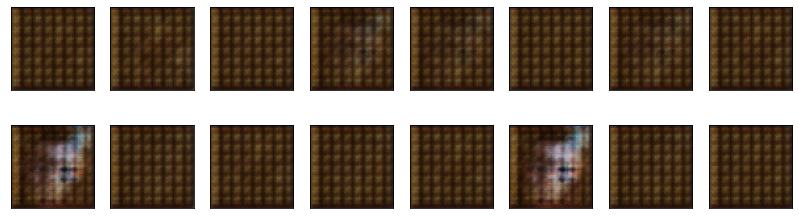

2023-07-29 13:58:59 | Epoch [6/20] | Batch 0/509 | d_loss: 0.3309 | g_loss: 7.7875
2023-07-29 13:59:20 | Epoch [6/20] | Batch 50/509 | d_loss: 0.3411 | g_loss: 9.2129
2023-07-29 13:59:40 | Epoch [6/20] | Batch 100/509 | d_loss: 0.3309 | g_loss: 7.1506
2023-07-29 14:00:01 | Epoch [6/20] | Batch 150/509 | d_loss: 0.3411 | g_loss: 8.6419
2023-07-29 14:00:21 | Epoch [6/20] | Batch 200/509 | d_loss: 0.3369 | g_loss: 7.9399
2023-07-29 14:00:41 | Epoch [6/20] | Batch 250/509 | d_loss: 0.3304 | g_loss: 7.8809
2023-07-29 14:01:02 | Epoch [6/20] | Batch 300/509 | d_loss: 0.3373 | g_loss: 7.5293
2023-07-29 14:01:22 | Epoch [6/20] | Batch 350/509 | d_loss: 0.3399 | g_loss: 6.7212
2023-07-29 14:01:43 | Epoch [6/20] | Batch 400/509 | d_loss: 0.3302 | g_loss: 8.1162
2023-07-29 14:02:03 | Epoch [6/20] | Batch 450/509 | d_loss: 0.3321 | g_loss: 7.8157
2023-07-29 14:02:23 | Epoch [6/20] | Batch 500/509 | d_loss: 0.3282 | g_loss: 7.9562


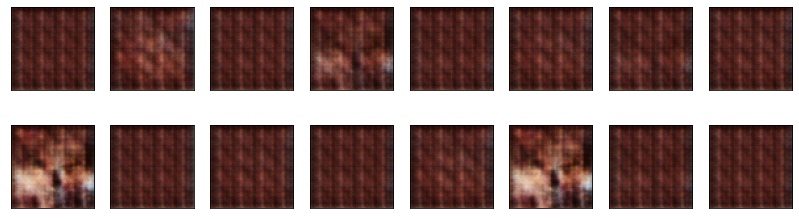

2023-07-29 14:02:29 | Epoch [7/20] | Batch 0/509 | d_loss: 0.3307 | g_loss: 7.5270
2023-07-29 14:02:50 | Epoch [7/20] | Batch 50/509 | d_loss: 0.3345 | g_loss: 7.0051
2023-07-29 14:03:10 | Epoch [7/20] | Batch 100/509 | d_loss: 0.3495 | g_loss: 8.8044
2023-07-29 14:03:30 | Epoch [7/20] | Batch 150/509 | d_loss: 0.3297 | g_loss: 8.6212
2023-07-29 14:03:51 | Epoch [7/20] | Batch 200/509 | d_loss: 0.3312 | g_loss: 7.6169
2023-07-29 14:04:11 | Epoch [7/20] | Batch 250/509 | d_loss: 0.3297 | g_loss: 8.2650
2023-07-29 14:04:32 | Epoch [7/20] | Batch 300/509 | d_loss: 0.3340 | g_loss: 7.2314
2023-07-29 14:04:52 | Epoch [7/20] | Batch 350/509 | d_loss: 0.3311 | g_loss: 7.4627
2023-07-29 14:05:12 | Epoch [7/20] | Batch 400/509 | d_loss: 0.3331 | g_loss: 8.0670
2023-07-29 14:05:33 | Epoch [7/20] | Batch 450/509 | d_loss: 0.3315 | g_loss: 7.3673
2023-07-29 14:05:53 | Epoch [7/20] | Batch 500/509 | d_loss: 0.3332 | g_loss: 9.3713


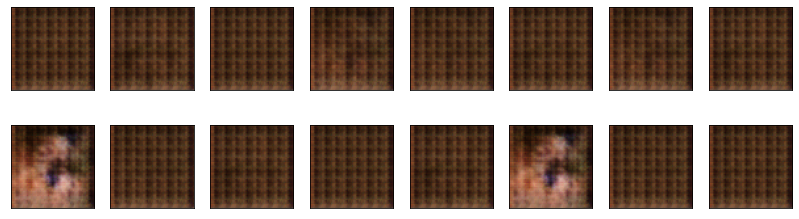

2023-07-29 14:05:59 | Epoch [8/20] | Batch 0/509 | d_loss: 0.3298 | g_loss: 6.8608
2023-07-29 14:06:20 | Epoch [8/20] | Batch 50/509 | d_loss: 0.3289 | g_loss: 7.2425
2023-07-29 14:06:40 | Epoch [8/20] | Batch 100/509 | d_loss: 0.3293 | g_loss: 7.3077
2023-07-29 14:07:01 | Epoch [8/20] | Batch 150/509 | d_loss: 0.3405 | g_loss: 8.4432
2023-07-29 14:07:21 | Epoch [8/20] | Batch 200/509 | d_loss: 0.3287 | g_loss: 7.8150
2023-07-29 14:07:41 | Epoch [8/20] | Batch 250/509 | d_loss: 0.3371 | g_loss: 8.3307
2023-07-29 14:08:02 | Epoch [8/20] | Batch 300/509 | d_loss: 0.3283 | g_loss: 7.6258
2023-07-29 14:08:22 | Epoch [8/20] | Batch 350/509 | d_loss: 0.3288 | g_loss: 8.4790
2023-07-29 14:08:43 | Epoch [8/20] | Batch 400/509 | d_loss: 0.3289 | g_loss: 8.0320
2023-07-29 14:09:03 | Epoch [8/20] | Batch 450/509 | d_loss: 0.3283 | g_loss: 8.3597
2023-07-29 14:09:23 | Epoch [8/20] | Batch 500/509 | d_loss: 0.3290 | g_loss: 9.2110


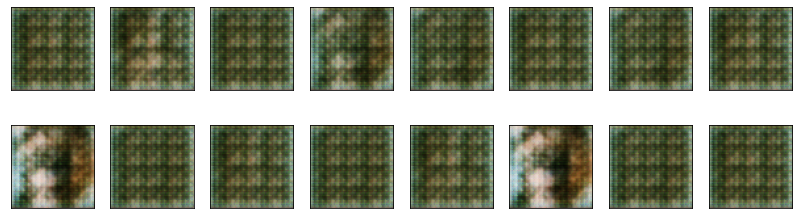

2023-07-29 14:09:29 | Epoch [9/20] | Batch 0/509 | d_loss: 0.3500 | g_loss: 7.6698
2023-07-29 14:09:50 | Epoch [9/20] | Batch 50/509 | d_loss: 0.3293 | g_loss: 7.6684
2023-07-29 14:10:10 | Epoch [9/20] | Batch 100/509 | d_loss: 0.3322 | g_loss: 8.5835
2023-07-29 14:10:31 | Epoch [9/20] | Batch 150/509 | d_loss: 0.3272 | g_loss: 10.6065
2023-07-29 14:10:51 | Epoch [9/20] | Batch 200/509 | d_loss: 0.3293 | g_loss: 8.2239
2023-07-29 14:11:11 | Epoch [9/20] | Batch 250/509 | d_loss: 0.3355 | g_loss: 7.5089
2023-07-29 14:11:32 | Epoch [9/20] | Batch 300/509 | d_loss: 0.3283 | g_loss: 7.8873
2023-07-29 14:11:52 | Epoch [9/20] | Batch 350/509 | d_loss: 0.3286 | g_loss: 7.3337
2023-07-29 14:12:13 | Epoch [9/20] | Batch 400/509 | d_loss: 0.3324 | g_loss: 7.9599
2023-07-29 14:12:33 | Epoch [9/20] | Batch 450/509 | d_loss: 0.3311 | g_loss: 8.5658
2023-07-29 14:12:53 | Epoch [9/20] | Batch 500/509 | d_loss: 0.3303 | g_loss: 6.9577


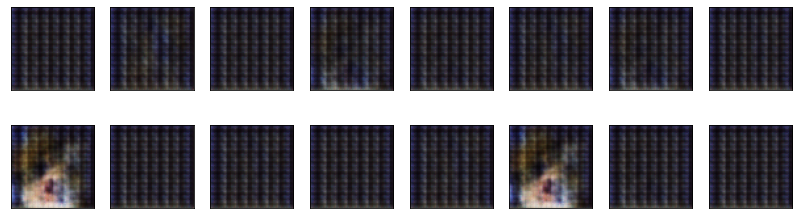

2023-07-29 14:12:59 | Epoch [10/20] | Batch 0/509 | d_loss: 0.3285 | g_loss: 9.2227
2023-07-29 14:13:20 | Epoch [10/20] | Batch 50/509 | d_loss: 0.3298 | g_loss: 8.1898
2023-07-29 14:13:40 | Epoch [10/20] | Batch 100/509 | d_loss: 0.3303 | g_loss: 8.1195
2023-07-29 14:14:01 | Epoch [10/20] | Batch 150/509 | d_loss: 0.3284 | g_loss: 7.5022
2023-07-29 14:14:21 | Epoch [10/20] | Batch 200/509 | d_loss: 0.3297 | g_loss: 7.0065
2023-07-29 14:14:42 | Epoch [10/20] | Batch 250/509 | d_loss: 0.3302 | g_loss: 7.2350
2023-07-29 14:15:02 | Epoch [10/20] | Batch 300/509 | d_loss: 0.3287 | g_loss: 9.1568
2023-07-29 14:15:22 | Epoch [10/20] | Batch 350/509 | d_loss: 0.3280 | g_loss: 8.4659
2023-07-29 14:15:43 | Epoch [10/20] | Batch 400/509 | d_loss: 0.3272 | g_loss: 8.3001
2023-07-29 14:16:03 | Epoch [10/20] | Batch 450/509 | d_loss: 0.3302 | g_loss: 7.1923
2023-07-29 14:16:24 | Epoch [10/20] | Batch 500/509 | d_loss: 0.3333 | g_loss: 8.8613


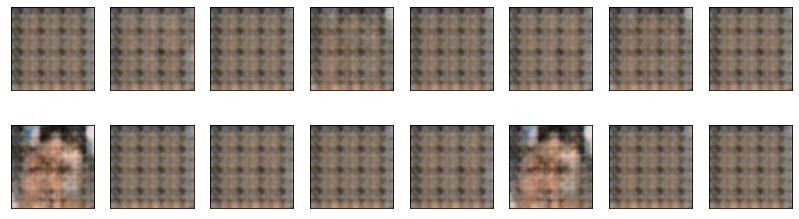

2023-07-29 14:16:30 | Epoch [11/20] | Batch 0/509 | d_loss: 0.3359 | g_loss: 8.1164
2023-07-29 14:16:50 | Epoch [11/20] | Batch 50/509 | d_loss: 0.3333 | g_loss: 7.3421
2023-07-29 14:17:10 | Epoch [11/20] | Batch 100/509 | d_loss: 0.3304 | g_loss: 8.4849
2023-07-29 14:17:31 | Epoch [11/20] | Batch 150/509 | d_loss: 0.3281 | g_loss: 9.4728
2023-07-29 14:17:51 | Epoch [11/20] | Batch 200/509 | d_loss: 0.3268 | g_loss: 8.2932
2023-07-29 14:18:11 | Epoch [11/20] | Batch 250/509 | d_loss: 0.3263 | g_loss: 9.5316
2023-07-29 14:18:32 | Epoch [11/20] | Batch 300/509 | d_loss: 0.3302 | g_loss: 7.7598
2023-07-29 14:18:52 | Epoch [11/20] | Batch 350/509 | d_loss: 0.3407 | g_loss: 11.9850
2023-07-29 14:19:13 | Epoch [11/20] | Batch 400/509 | d_loss: 0.3340 | g_loss: 8.3456
2023-07-29 14:19:33 | Epoch [11/20] | Batch 450/509 | d_loss: 0.3320 | g_loss: 9.3167
2023-07-29 14:19:53 | Epoch [11/20] | Batch 500/509 | d_loss: 0.3264 | g_loss: 8.5825


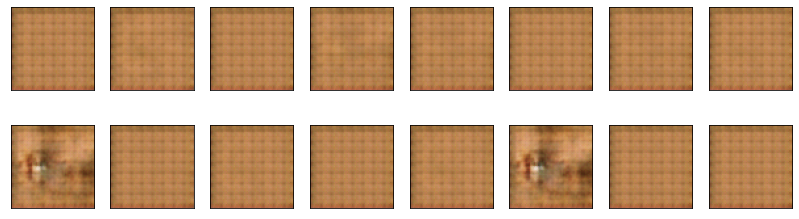

2023-07-29 14:20:00 | Epoch [12/20] | Batch 0/509 | d_loss: 0.3272 | g_loss: 7.7616
2023-07-29 14:20:20 | Epoch [12/20] | Batch 50/509 | d_loss: 0.3266 | g_loss: 8.1106
2023-07-29 14:20:41 | Epoch [12/20] | Batch 100/509 | d_loss: 0.3282 | g_loss: 7.3471
2023-07-29 14:21:01 | Epoch [12/20] | Batch 150/509 | d_loss: 0.3309 | g_loss: 7.9933
2023-07-29 14:21:21 | Epoch [12/20] | Batch 200/509 | d_loss: 0.3294 | g_loss: 7.5886
2023-07-29 14:21:42 | Epoch [12/20] | Batch 250/509 | d_loss: 0.3274 | g_loss: 7.7421
2023-07-29 14:22:02 | Epoch [12/20] | Batch 300/509 | d_loss: 0.3385 | g_loss: 7.5297
2023-07-29 14:22:23 | Epoch [12/20] | Batch 350/509 | d_loss: 0.3282 | g_loss: 7.5879
2023-07-29 14:22:43 | Epoch [12/20] | Batch 400/509 | d_loss: 0.3280 | g_loss: 8.8934
2023-07-29 14:23:03 | Epoch [12/20] | Batch 450/509 | d_loss: 0.3390 | g_loss: 7.5337
2023-07-29 14:23:24 | Epoch [12/20] | Batch 500/509 | d_loss: 0.3284 | g_loss: 7.4452


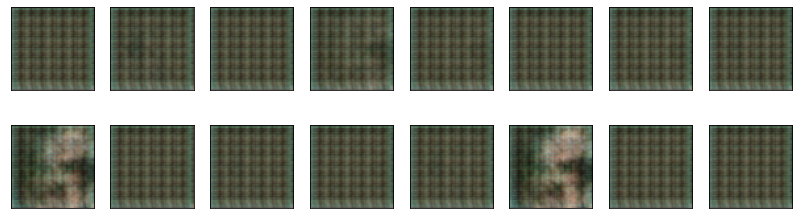

2023-07-29 14:23:30 | Epoch [13/20] | Batch 0/509 | d_loss: 0.3273 | g_loss: 8.8458
2023-07-29 14:23:50 | Epoch [13/20] | Batch 50/509 | d_loss: 0.3327 | g_loss: 8.0490
2023-07-29 14:24:11 | Epoch [13/20] | Batch 100/509 | d_loss: 0.3261 | g_loss: 10.0911
2023-07-29 14:24:31 | Epoch [13/20] | Batch 150/509 | d_loss: 0.3262 | g_loss: 8.9821
2023-07-29 14:24:51 | Epoch [13/20] | Batch 200/509 | d_loss: 0.3283 | g_loss: 8.1299
2023-07-29 14:25:12 | Epoch [13/20] | Batch 250/509 | d_loss: 0.3277 | g_loss: 7.8269
2023-07-29 14:25:32 | Epoch [13/20] | Batch 300/509 | d_loss: 0.3430 | g_loss: 5.6369
2023-07-29 14:25:53 | Epoch [13/20] | Batch 350/509 | d_loss: 0.3378 | g_loss: 7.1761
2023-07-29 14:26:13 | Epoch [13/20] | Batch 400/509 | d_loss: 0.3355 | g_loss: 6.2949
2023-07-29 14:26:34 | Epoch [13/20] | Batch 450/509 | d_loss: 0.3330 | g_loss: 6.6387
2023-07-29 14:26:54 | Epoch [13/20] | Batch 500/509 | d_loss: 0.3436 | g_loss: 7.7979


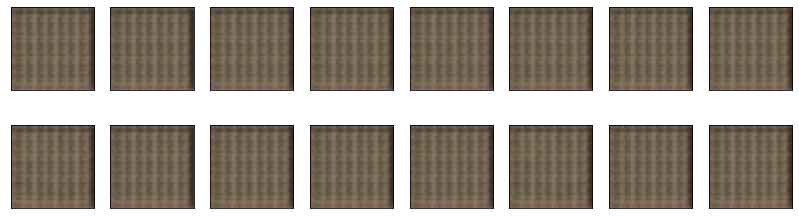

2023-07-29 14:27:00 | Epoch [14/20] | Batch 0/509 | d_loss: 0.3329 | g_loss: 7.4507
2023-07-29 14:27:20 | Epoch [14/20] | Batch 50/509 | d_loss: 0.3295 | g_loss: 8.7385
2023-07-29 14:27:41 | Epoch [14/20] | Batch 100/509 | d_loss: 0.3311 | g_loss: 8.2014
2023-07-29 14:28:01 | Epoch [14/20] | Batch 150/509 | d_loss: 0.3313 | g_loss: 8.2007
2023-07-29 14:28:22 | Epoch [14/20] | Batch 200/509 | d_loss: 0.3288 | g_loss: 8.0083
2023-07-29 14:28:42 | Epoch [14/20] | Batch 250/509 | d_loss: 0.3292 | g_loss: 7.5758
2023-07-29 14:29:02 | Epoch [14/20] | Batch 300/509 | d_loss: 0.3273 | g_loss: 8.4001
2023-07-29 14:29:23 | Epoch [14/20] | Batch 350/509 | d_loss: 0.3333 | g_loss: 6.9676
2023-07-29 14:29:43 | Epoch [14/20] | Batch 400/509 | d_loss: 0.3329 | g_loss: 7.6214
2023-07-29 14:30:03 | Epoch [14/20] | Batch 450/509 | d_loss: 0.3282 | g_loss: 8.2206
2023-07-29 14:30:24 | Epoch [14/20] | Batch 500/509 | d_loss: 0.3302 | g_loss: 7.7288


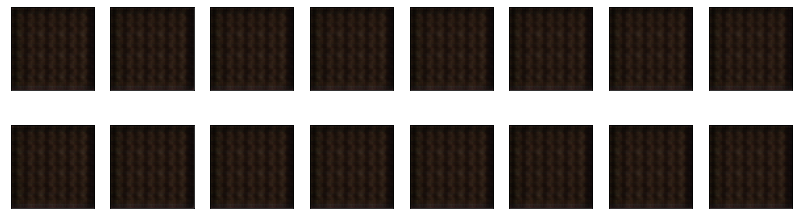

2023-07-29 14:30:30 | Epoch [15/20] | Batch 0/509 | d_loss: 0.3288 | g_loss: 8.0762
2023-07-29 14:30:50 | Epoch [15/20] | Batch 50/509 | d_loss: 0.3343 | g_loss: 7.7093
2023-07-29 14:31:10 | Epoch [15/20] | Batch 100/509 | d_loss: 0.3300 | g_loss: 7.6998
2023-07-29 14:31:31 | Epoch [15/20] | Batch 150/509 | d_loss: 0.3277 | g_loss: 7.3510
2023-07-29 14:31:51 | Epoch [15/20] | Batch 200/509 | d_loss: 0.3354 | g_loss: 6.9941
2023-07-29 14:32:12 | Epoch [15/20] | Batch 250/509 | d_loss: 0.3293 | g_loss: 7.5667
2023-07-29 14:32:32 | Epoch [15/20] | Batch 300/509 | d_loss: 0.3465 | g_loss: 4.4899
2023-07-29 14:32:52 | Epoch [15/20] | Batch 350/509 | d_loss: 0.3468 | g_loss: 10.1870
2023-07-29 14:33:13 | Epoch [15/20] | Batch 400/509 | d_loss: 0.3413 | g_loss: 9.0010
2023-07-29 14:33:33 | Epoch [15/20] | Batch 450/509 | d_loss: 0.3374 | g_loss: 7.8608
2023-07-29 14:33:53 | Epoch [15/20] | Batch 500/509 | d_loss: 0.3286 | g_loss: 7.3271


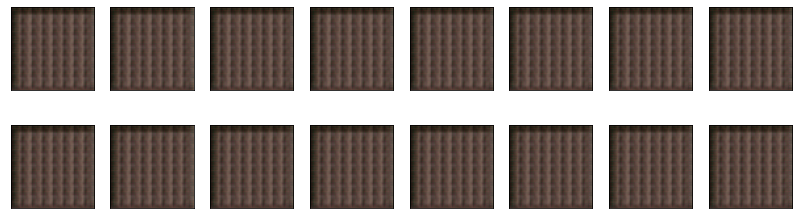

2023-07-29 14:33:59 | Epoch [16/20] | Batch 0/509 | d_loss: 0.3307 | g_loss: 7.8970
2023-07-29 14:34:20 | Epoch [16/20] | Batch 50/509 | d_loss: 0.3299 | g_loss: 11.8935
2023-07-29 14:34:40 | Epoch [16/20] | Batch 100/509 | d_loss: 0.3410 | g_loss: 7.8583
2023-07-29 14:35:00 | Epoch [16/20] | Batch 150/509 | d_loss: 0.3359 | g_loss: 9.2101
2023-07-29 14:35:21 | Epoch [16/20] | Batch 200/509 | d_loss: 0.3297 | g_loss: 7.6414
2023-07-29 14:35:41 | Epoch [16/20] | Batch 250/509 | d_loss: 0.3320 | g_loss: 7.9201
2023-07-29 14:36:01 | Epoch [16/20] | Batch 300/509 | d_loss: 0.3316 | g_loss: 8.2844
2023-07-29 14:36:22 | Epoch [16/20] | Batch 350/509 | d_loss: 0.3357 | g_loss: 6.6676
2023-07-29 14:36:42 | Epoch [16/20] | Batch 400/509 | d_loss: 0.3313 | g_loss: 7.2671
2023-07-29 14:37:03 | Epoch [16/20] | Batch 450/509 | d_loss: 0.3333 | g_loss: 7.1145
2023-07-29 14:37:23 | Epoch [16/20] | Batch 500/509 | d_loss: 0.3332 | g_loss: 7.9232


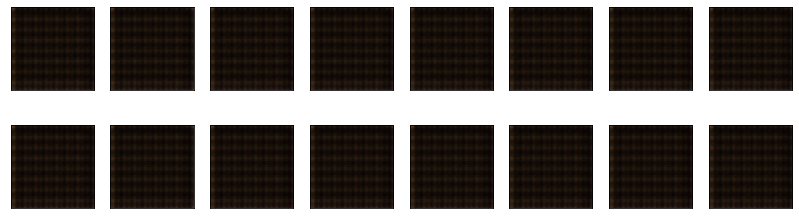

2023-07-29 14:37:29 | Epoch [17/20] | Batch 0/509 | d_loss: 0.3300 | g_loss: 7.0761
2023-07-29 14:37:49 | Epoch [17/20] | Batch 50/509 | d_loss: 0.3366 | g_loss: 6.3667
2023-07-29 14:38:10 | Epoch [17/20] | Batch 100/509 | d_loss: 0.3321 | g_loss: 7.6522
2023-07-29 14:38:30 | Epoch [17/20] | Batch 150/509 | d_loss: 0.3419 | g_loss: 6.2631
2023-07-29 14:38:50 | Epoch [17/20] | Batch 200/509 | d_loss: 0.3295 | g_loss: 8.4453
2023-07-29 14:39:11 | Epoch [17/20] | Batch 250/509 | d_loss: 0.3385 | g_loss: 6.0512
2023-07-29 14:39:31 | Epoch [17/20] | Batch 300/509 | d_loss: 0.3364 | g_loss: 7.0307
2023-07-29 14:39:52 | Epoch [17/20] | Batch 350/509 | d_loss: 0.3330 | g_loss: 7.0340
2023-07-29 14:40:12 | Epoch [17/20] | Batch 400/509 | d_loss: 0.3573 | g_loss: 6.0941
2023-07-29 14:40:32 | Epoch [17/20] | Batch 450/509 | d_loss: 0.3352 | g_loss: 7.2450
2023-07-29 14:40:53 | Epoch [17/20] | Batch 500/509 | d_loss: 0.3314 | g_loss: 8.5533


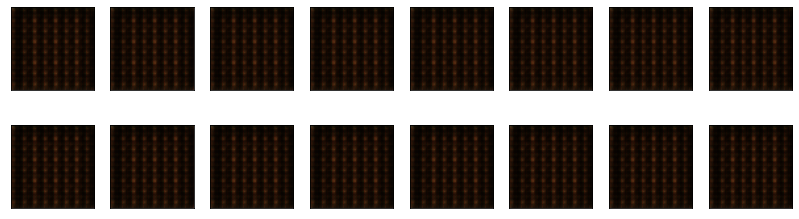

2023-07-29 14:40:59 | Epoch [18/20] | Batch 0/509 | d_loss: 0.3317 | g_loss: 7.0963
2023-07-29 14:41:19 | Epoch [18/20] | Batch 50/509 | d_loss: 0.3416 | g_loss: 6.4270
2023-07-29 14:41:39 | Epoch [18/20] | Batch 100/509 | d_loss: 0.3381 | g_loss: 11.3337
2023-07-29 14:42:00 | Epoch [18/20] | Batch 150/509 | d_loss: 0.3314 | g_loss: 7.8898
2023-07-29 14:42:20 | Epoch [18/20] | Batch 200/509 | d_loss: 0.3368 | g_loss: 6.4331
2023-07-29 14:42:40 | Epoch [18/20] | Batch 250/509 | d_loss: 0.3309 | g_loss: 7.9980
2023-07-29 14:43:01 | Epoch [18/20] | Batch 300/509 | d_loss: 0.3306 | g_loss: 7.4135
2023-07-29 14:43:21 | Epoch [18/20] | Batch 350/509 | d_loss: 0.3310 | g_loss: 7.2941
2023-07-29 14:43:42 | Epoch [18/20] | Batch 400/509 | d_loss: 0.3301 | g_loss: 7.8437
2023-07-29 14:44:02 | Epoch [18/20] | Batch 450/509 | d_loss: 0.3311 | g_loss: 9.7027
2023-07-29 14:44:23 | Epoch [18/20] | Batch 500/509 | d_loss: 0.3302 | g_loss: 8.0125


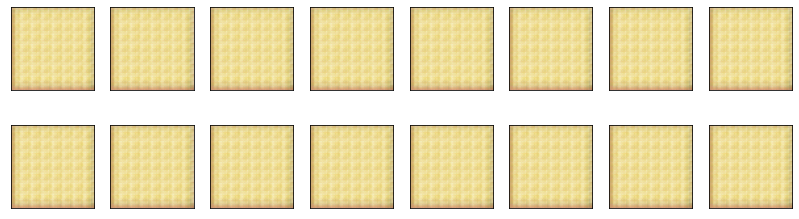

2023-07-29 14:44:29 | Epoch [19/20] | Batch 0/509 | d_loss: 0.3334 | g_loss: 8.4753
2023-07-29 14:44:49 | Epoch [19/20] | Batch 50/509 | d_loss: 0.3299 | g_loss: 8.5487
2023-07-29 14:45:09 | Epoch [19/20] | Batch 100/509 | d_loss: 0.3326 | g_loss: 8.5291
2023-07-29 14:45:30 | Epoch [19/20] | Batch 150/509 | d_loss: 0.3320 | g_loss: 8.1484
2023-07-29 14:45:50 | Epoch [19/20] | Batch 200/509 | d_loss: 0.3322 | g_loss: 7.0849
2023-07-29 14:46:11 | Epoch [19/20] | Batch 250/509 | d_loss: 0.3355 | g_loss: 7.9494
2023-07-29 14:46:31 | Epoch [19/20] | Batch 300/509 | d_loss: 0.3292 | g_loss: 7.1768
2023-07-29 14:46:51 | Epoch [19/20] | Batch 350/509 | d_loss: 0.3354 | g_loss: 6.3956
2023-07-29 14:47:12 | Epoch [19/20] | Batch 400/509 | d_loss: 0.3342 | g_loss: 6.8608
2023-07-29 14:47:32 | Epoch [19/20] | Batch 450/509 | d_loss: 0.3304 | g_loss: 7.9476
2023-07-29 14:47:52 | Epoch [19/20] | Batch 500/509 | d_loss: 0.3315 | g_loss: 7.9223


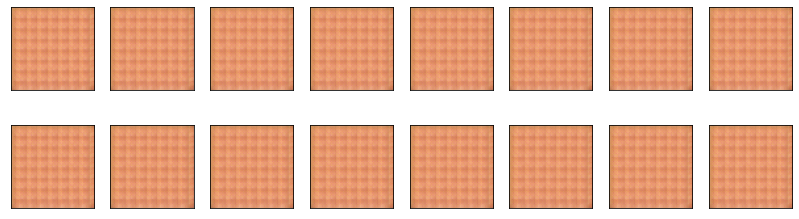

2023-07-29 14:47:58 | Epoch [20/20] | Batch 0/509 | d_loss: 0.3368 | g_loss: 6.6630
2023-07-29 14:48:19 | Epoch [20/20] | Batch 50/509 | d_loss: 0.3334 | g_loss: 6.9811
2023-07-29 14:48:39 | Epoch [20/20] | Batch 100/509 | d_loss: 0.3342 | g_loss: 8.8190
2023-07-29 14:49:00 | Epoch [20/20] | Batch 150/509 | d_loss: 0.3311 | g_loss: 7.2773
2023-07-29 14:49:20 | Epoch [20/20] | Batch 200/509 | d_loss: 0.3333 | g_loss: 7.5298
2023-07-29 14:49:41 | Epoch [20/20] | Batch 250/509 | d_loss: 0.3311 | g_loss: 7.2006
2023-07-29 14:50:01 | Epoch [20/20] | Batch 300/509 | d_loss: 0.3307 | g_loss: 6.8619
2023-07-29 14:50:21 | Epoch [20/20] | Batch 350/509 | d_loss: 0.3498 | g_loss: 5.8094
2023-07-29 14:50:42 | Epoch [20/20] | Batch 400/509 | d_loss: 0.3322 | g_loss: 8.0296
2023-07-29 14:51:02 | Epoch [20/20] | Batch 450/509 | d_loss: 0.3359 | g_loss: 10.4590
2023-07-29 14:51:23 | Epoch [20/20] | Batch 500/509 | d_loss: 0.3332 | g_loss: 7.8137


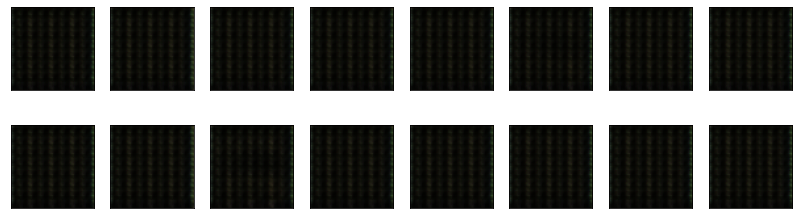

In [24]:
fixed_latent_vector = torch.randn(16, latent_dim, 1, 1).float().to(device)

losses = []
for epoch in range(n_epochs):
    for batch_i, real_images in enumerate(dataloader):
        real_images = real_images.to(device)
        
        ####################################
        
        # TODO: implement the training strategy
        
        ####################################
        g_loss = generator_step(batch_size, latent_dim)
        d_loss = discriminator_step(batch_size, latent_dim, real_images)
        
        if batch_i % print_every == 0:
            # append discriminator loss and generator loss
            d = d_loss['loss'].item()
            g = g_loss['loss'].item()
            losses.append((d, g))
            # print discriminator and generator loss
            time = str(datetime.now()).split('.')[0]
            print(f'{time} | Epoch [{epoch+1}/{n_epochs}] | Batch {batch_i}/{len(dataloader)} | d_loss: {d:.4f} | g_loss: {g:.4f}')
    
    # display images during training
    generator.eval()
    generated_images = generator(fixed_latent_vector)
    display(generated_images)
    generator.train()

### Training losses

Plot the training losses for the generator and discriminator.

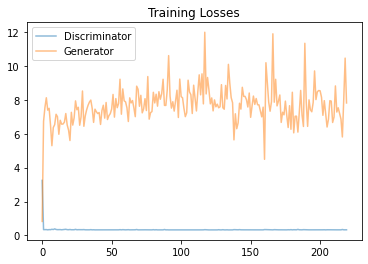

In [25]:
"""
DO NOT MODIFY ANYTHING IN THIS CELL
"""
fig, ax = plt.subplots()
losses = np.array(losses)
plt.plot(losses.T[0], label='Discriminator', alpha=0.5)
plt.plot(losses.T[1], label='Generator', alpha=0.5)
plt.title("Training Losses")
plt.legend()

### Question: What do you notice about your generated samples and how might you improve this model?
When you answer this question, consider the following factors:
* The dataset is biased; it is made of "celebrity" faces that are mostly white
* Model size; larger models have the opportunity to learn more features in a data feature space
* Optimization strategy; optimizers and number of epochs affect your final result
* Loss functions

**Answer:** (Write your answer in this cell)

### Submitting This Project
When submitting this project, make sure to run all the cells before saving the notebook. Save the notebook file as "dlnd_face_generation.ipynb".  

Submit the notebook using the ***SUBMIT*** button in the bottom right corner of the Project Workspace.